In [1]:
from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *


import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from mplsoccer import *
import pandas as pd
import numpy as np
import os

from mplsoccer import Pitch
import ipywidgets as widgets
from IPython.display import display
from sklearn.neighbors import KDTree

# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


Button(button_style='success', description='Save Situation', style=ButtonStyle())

Button(button_style='warning', description='Clear', style=ButtonStyle())

Button(button_style='info', description='Toggle Draw Vector', style=ButtonStyle())

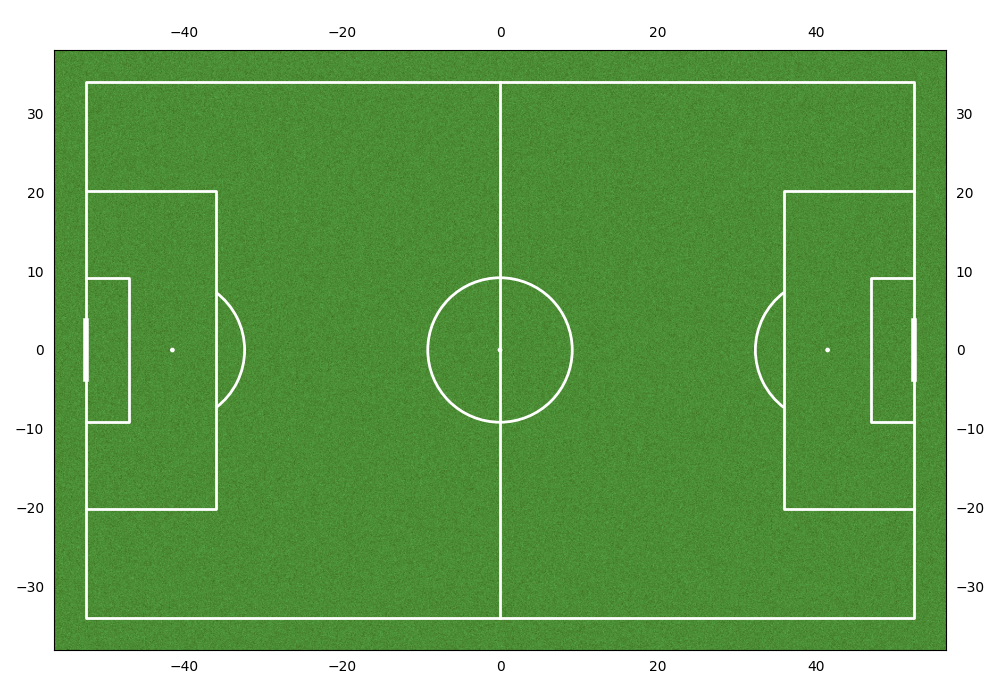

: 

In [2]:
%matplotlib widget
# Initialize plot
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# List to store points for the current situation and vectors
points = [] 
vectors = []
situations = []

# Boolean to check if we're in vector drawing mode
draw_vector_mode = False
vector_start = None  # To store the start point of the vector

# Function to handle mouse clicks for points and vectors
def on_click(event):
    global vector_start, draw_vector_mode
    
    if event.inaxes:  # Check if click is inside plot
        x, y = event.xdata, event.ydata  # Get coordinates
        
        if draw_vector_mode:
            if vector_start is None:  # If no start point, set this as start point
                vector_start = (x, y)
                ax.plot(x, y, 'bo')  # Mark the start point with a blue dot
            else:
                # If there's already a start point, draw the vector from start to this point
                vector_end = (x, y)
                ax.annotate('', xy=vector_end, xytext=vector_start,
                            arrowprops=dict(facecolor='red', shrink=0.05))  # Draw vector
                vectors.append((vector_start, vector_end))  # Save the vector
                vector_start = None  # Reset the start point
        else:
            points.append((x, y))  # Add to list of points
            ax.plot(x, y, 'ro')  # Plot the point
        
        plt.draw()  # Redraw the figure

# Function to save the current situation
def save_situation(_):
    if points or vectors:
        situations.append({'points': list(points), 'vectors': list(vectors)})  # Save the current points and vectors
        print(f"Situation saved! Total saved situations: {len(situations)}")
    else:
        print("No players or vectors to save!")

# Function to clear the current situation
def clear_situation(_):
    global points, vectors, vector_start
    points = []  # Clear the current points
    vectors = []  # Clear the current vectors
    vector_start = None  # Reset vector start point
    ax.cla()  # Clear the plot
    football_pitch.draw(ax=ax)  # Redraw the empty pitch
    plt.draw()
    print("Cleared the current situation. You can now draw a new one.")

# Function to toggle vector drawing mode
def toggle_draw_vector(_):
    global draw_vector_mode
    draw_vector_mode = not draw_vector_mode  # Toggle the mode
    if draw_vector_mode:
        print("Vector drawing mode enabled. Select start and end points for the vector.")
    else:
        print("Switched to player drawing mode.")

# Create save, clear, and toggle vector buttons
save_button = widgets.Button(description="Save Situation", button_style='success')
clear_button = widgets.Button(description="Clear", button_style='warning')
toggle_vector_button = widgets.Button(description="Toggle Draw Vector", button_style='info')

# Connect button click events to their functions
save_button.on_click(save_situation)
clear_button.on_click(clear_situation)
toggle_vector_button.on_click(toggle_draw_vector)

# Display the buttons below the plot
display(save_button, clear_button, toggle_vector_button)

# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()


In [3]:
situations

[{'points': [(np.float64(-53.17067413643732), np.float64(34.16610577484583)),
   (np.float64(41.47228089034729), np.float64(0.33790096607543063)),
   (np.float64(-48.98966005894884), np.float64(9.966903083927676)),
   (np.float64(-49.11635745523637), np.float64(-1.0557703930873927)),
   (np.float64(-49.2430548515239), np.float64(-8.657614170339173)),
   (np.float64(-41.64121107427212), np.float64(-3.463020922550456)),
   (np.float64(-43.6683694148726), np.float64(2.1116645141008448)),
   (np.float64(-35.68643344875824), np.float64(0.08450617350037248)),
   (np.float64(-23.396786008867863), np.float64(-4.4766000928506955)),
   (np.float64(-11.48723075784008), np.float64(4.138822854701317)),
   (np.float64(-35.939828241333295), np.float64(-8.15082458518905))],
  'vectors': []}]

Collected 11 points.


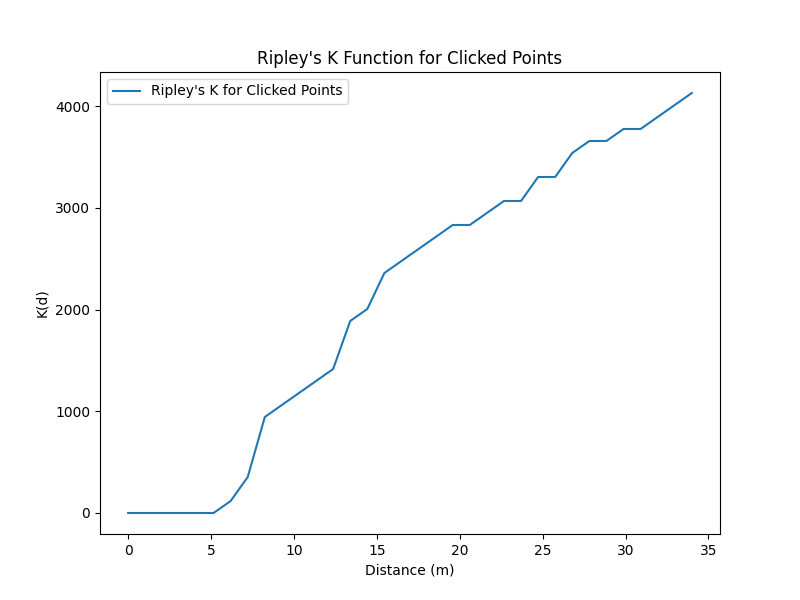

In [4]:
# Ensure the interactive pitch has captured points
if not points:
    print("Please click on the pitch to add points.")
else:
    print(f"Collected {len(points)} points.")

# Step 2: Convert the points from the interactive pitch into a usable format
points_array = np.array(points)  # Convert the collected points into a NumPy array

if points_array.shape[0] > 1:
    # Flatten the points for Ripley's K
    points_series = pd.Series(points_array.flatten())

    # Step 3: Define the radii for Ripley's K
    radii = np.linspace(0, 34, 34)  # Adjust the range based on your use case

    # Step 4: Calculate Ripley's K for the clicked points
    k_values_clicked = ripley_k(points_series, radii, width=105.0, height=68.0)

    # Step 5: Plot Ripley's K values for the clicked points
    plt.figure(figsize=(8, 6))
    plt.plot(radii, k_values_clicked, label="Ripley's K for Clicked Points")
    plt.xlabel('Distance (m)')
    plt.ylabel("K(d)")
    plt.title("Ripley's K Function for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [6]:
# Step 6: Extract match data from tracking data
data = compile_team_tracking_data("data/H_EURO2024GERMANY", "Denmark")
one_match = extract_one_match(data, 1)



In [7]:
mean_xy = calculate_xy_mean(one_match.iloc[::48].filter(regex="^home").to_numpy())

[[ 1.88639832e+01  6.93741989e+00  1.61913834e+01 ...             nan
              nan             nan]
 [ 1.96943893e+01  8.17001247e+00  1.73564873e+01 ...             nan
              nan             nan]
 [ 2.29275932e+01  7.91264629e+00  2.23328819e+01 ...             nan
              nan             nan]
 ...
 [ 2.86781490e-01  1.49834132e+00  2.61340809e+01 ...  1.88612080e+01
   3.24168358e+01  1.21793385e+01]
 [ 2.70689353e-02 -3.44101310e+00  1.63819656e+01 ...  1.69635353e+01
   2.85937996e+01  1.29757814e+01]
 [ 7.67679587e-02 -6.92143583e+00  1.20290155e+01 ...  1.63264523e+01
   2.73052883e+01  1.11060858e+01]]


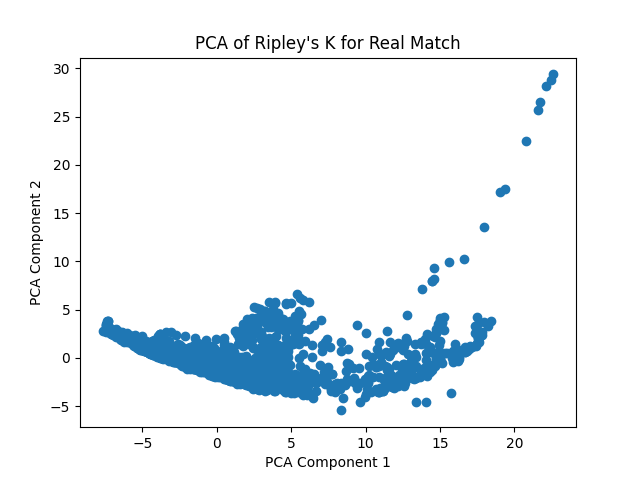

In [8]:
# Step 7: Calculate Ripley's K values for the real match data
ripley_k_vals = ripley_k_by_indices(one_match, one_match.iloc[::48].index)
ripley_k_vals = np.hstack((ripley_k_vals, mean_xy))

#Added average position of team as feature

# Step 8: Perform PCA on the Ripley's K values from the real match data
pca_obj_ripley = PCAObject(ripley_k_vals, 10)  # Fit PCA with 10 components
np_pca_ripley = pca_obj_ripley.transform(ripley_k_vals)




# Step 9: Plot the PCA-reduced Ripley's K values for the real match
plt.figure()
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1])
plt.title("PCA of Ripley's K for Real Match")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("pca_ripley.png")
plt.show()

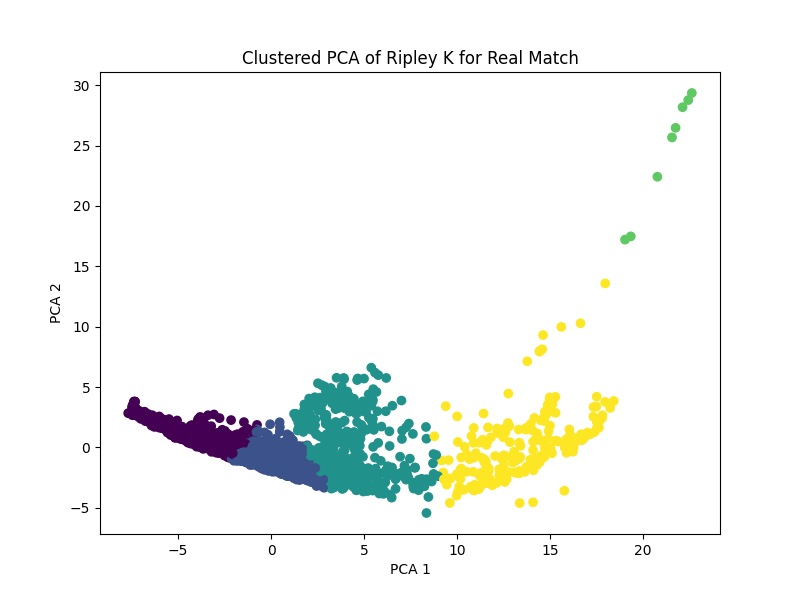

In [9]:
# Step 10: Cluster the PCA-reduced Ripley's K values using KMeans
clustering_obj_ripley = KMeansObject(np_pca_ripley, 5)  # Fit KMeans with 5 clusters
labels = clustering_obj_ripley.get_labels()

# Step 11: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clustered PCA of Ripley K for Real Match')
plt.savefig("pca_ripley_clustered.png")
plt.show()

[[-53.17067414  34.16610577  41.47228089   0.33790097 -48.98966006
    9.96690308 -49.11635746  -1.05577039 -49.24305485  -8.65761417
  -41.64121107  -3.46302092 -43.66836941   2.11166451 -35.68643345
    0.08450617 -23.39678601  -4.47660009 -11.48723076   4.13882285
  -35.93982824  -8.15082459]]
[[   0.            0.            0.            0.            0.
     0.          118.01652893  354.04958678  944.1322314  1062.14876033
  1180.16528926 1298.18181818 1416.19834711 1888.26446281 2006.28099174
  2360.33057851 2478.34710744 2596.36363636 2714.38016529 2832.39669421
  2832.39669421 2950.41322314 3068.42975207 3068.42975207 3304.46280992
  3304.46280992 3540.49586777 3658.51239669 3658.51239669 3776.52892562
  3776.52892562 3894.54545455 4012.56198347 4130.5785124 ]]
[[-31.89702951   2.27291575]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.18016529e+02  3.54049587e+02
   9.44132231e+02  1.06214876e+03  1.18016529e+03  1.298

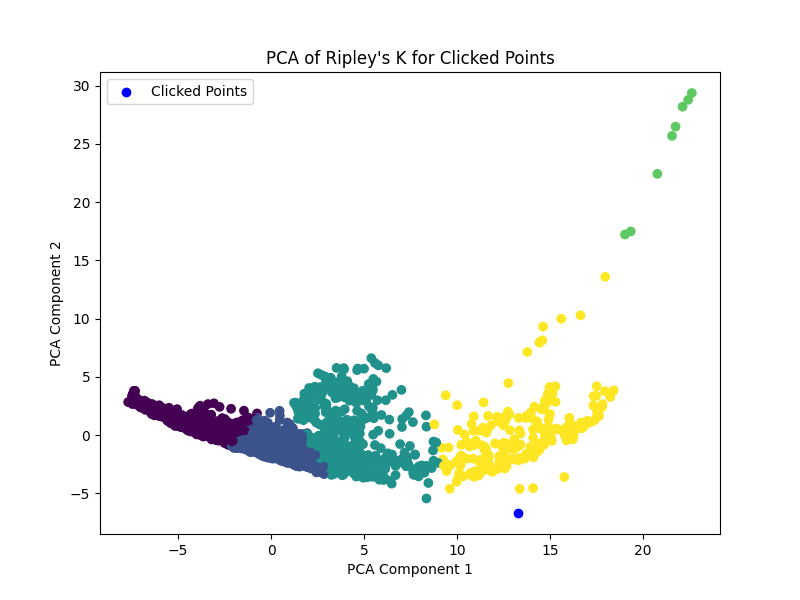

In [10]:
# Step 12: Apply PCA on the Ripley's K values for the clicked points
if points_array.shape[0] > 1:
    
    k_values_clicked_new = np.array(k_values_clicked).reshape(1, -1)  # Reshape for PCA compatibility
    xy_vals = calculate_xy_mean(points_array.flatten().reshape(1,-1))



    print(k_values_clicked_new)
    print(xy_vals)

    k_values_clicked_new = np.hstack((k_values_clicked_new, xy_vals))
    (print(k_values_clicked_new))
    reduced_k_values_clicked = pca_obj_ripley.transform(k_values_clicked_new)  # Transform using the same PCA model

    # Step 13: Plot the PCA-reduced clicked points

    plt.scatter(reduced_k_values_clicked[:, 0], reduced_k_values_clicked[:, 1], c='blue', label='Clicked Points')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title("PCA of Ripley's K for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [11]:

# Step 1: Build a KDTree from the PCA-reduced real match data
tree = KDTree(np_pca_ripley)

# Step 2: Query the 10 nearest neighbors for the clicked situation
distances, indices = tree.query(reduced_k_values_clicked, k=10)  # Find 10 nearest neighbors

# Flatten the indices
closest_indices = indices.flatten()
print("Closest situation indices:", closest_indices)


Closest situation indices: [2481 2479 2480 2478 1609 1616 1615 1610 1617 1612]


In [12]:
# Assuming `one_match` is a DataFrame where each row contains player positions for a specific situation
# Each row of `one_match` contains the player positions in the format: [(x1, y1), (x2, y2), ...]

# Retrieve the 10 closest situations from the real match
closest_situations = one_match.iloc[closest_indices]


In [13]:
closest_situations

,Time [s]_team,half_team,minute_team,Period_team,home_6_x,home_6_y,home_18_x,home_18_y,home_1_x,home_1_y,...,away_5_y,away_14_x,away_14_y,away_23_x,away_23_y,away_19_x,away_19_y,ball_x,ball_y,ball_z
2481,99.24,1H,1,1,-2.208404,-4.689851,-26.197447,8.464933,29.805950,-1.636503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.833888,-17.515021,0.274555
2479,99.16,1H,1,1,-2.274785,-4.669389,-26.161753,8.456036,29.826876,-1.612204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.878631,-18.744590,0.460818
2480,99.20,1H,1,1,-2.240466,-4.680793,-26.178459,8.460261,29.816307,-1.624797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.854848,-18.126869,0.376669
2478,99.12,1H,1,1,-2.314839,-4.655120,-26.145842,8.450040,29.837404,-1.599247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.911223,-19.367371,0.527408
1609,64.36,1H,1,1,-2.844944,-3.413862,-19.819773,26.143330,31.244541,-0.685776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.718822,-2.986518,0.193518
1616,64.64,1H,1,1,-2.813367,-3.001575,-19.032070,26.901487,31.210764,-0.509383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.760659,0.314817,0.214989
1615,64.60,1H,1,1,-2.823872,-3.062605,-19.151917,26.792015,31.217512,-0.530369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.755761,-0.148346,0.214950
1610,64.40,1H,1,1,-2.849352,-3.348281,-19.711887,26.248217,31.241175,-0.659977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.718982,-2.619137,0.205679
1617,64.68,1H,1,1,-2.800226,-2.941052,-18.912090,27.006525,31.203449,-0.491580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.768660,0.758465,0.218731
1612,64.48,1H,1,1,-2.844452,-3.235524,-19.495026,26.457691,31.232904,-0.607003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.736752,-1.591335,0.213669


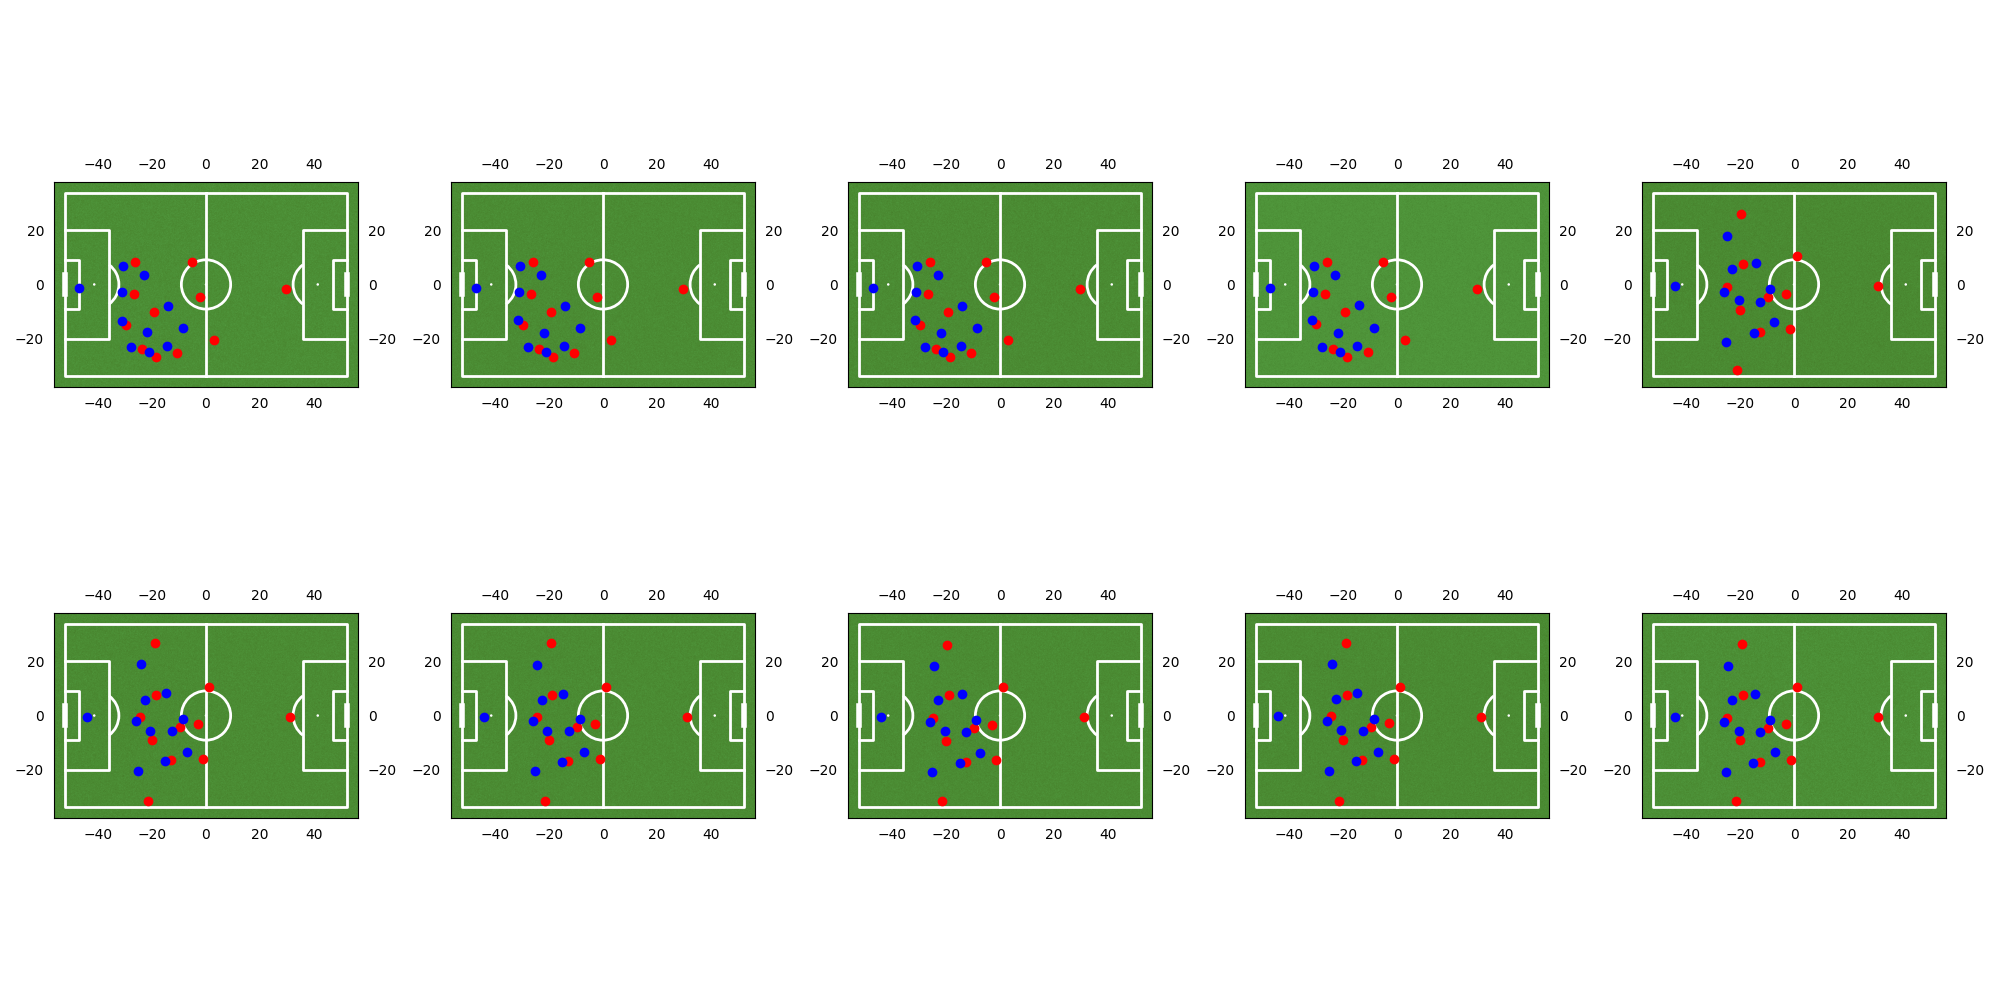

In [14]:
# Function to extract player coordinates from the DataFrame
def extract_player_positions(row):
    # Extract home player positions (x and y)
    home_x_cols = [col for col in row.index if 'home' in col and '_x' in col]
    home_y_cols = [col for col in row.index if 'home' in col and '_y' in col]
    
    home_positions = [(row[x], row[y]) for x, y in zip(home_x_cols, home_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    # Extract away player positions (x and y)
    away_x_cols = [col for col in row.index if 'away' in col and '_x' in col]
    away_y_cols = [col for col in row.index if 'away' in col and '_y' in col]
    
    away_positions = [(row[x], row[y]) for x, y in zip(away_x_cols, away_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    return home_positions, away_positions

# Function to plot a single situation on the pitch
def plot_situation(row, ax):
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax)
    
    # Extract player positions from the row
    home_positions, away_positions = extract_player_positions(row)
    
    # Plot home team players (red)
    for pos in home_positions:
        ax.plot(pos[0], pos[1], 'ro')  # Mark home players as red dots

    # Plot away team players (blue)
    for pos in away_positions:
        ax.plot(pos[0], pos[1], 'bo')  # Mark away players as blue dots

# Step 4: Visualize the 10 closest situations on the pitch
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create a grid for 10 situations
axes = axes.flatten()

# Iterate over the 10 closest situations and plot them
for idx, situation_index in enumerate(closest_situations.index):  # Use the index of the closest situations
    plot_situation(closest_situations.loc[situation_index], axes[idx])  # Pass the row to plot_situation

plt.tight_layout()
plt.show()
